### Data Engineering

In [40]:
#import libraries
import os
import pandas as pd
import numpy as np
import copy
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(32)
np.random.seed(32)
random.seed(32)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# dataFolder= '/content/drive/MyDrive/ECE1508/Code'
dataFolder = '.'
os.chdir(dataFolder)
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /content/drive/.shortcut-targets-by-id/1FsmqwEiZJAaz0p8i6_y9fb9O2BZref7v/ECE1508/Code


In [43]:
#load dataset
csvPath = "./data/btcusd_1-min_data.csv"

df = pd.read_csv(csvPath)

#convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True)
df.set_index('Timestamp', inplace=True)

#sort by datetime index
df.sort_index(inplace=True)

#print first 5 rows
df.head()


,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0


In [44]:
# print last 5 rows
df.tail()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-11-18 23:53:00+00:00,92836.0,92850.0,92819.0,92835.0,38.001801
2025-11-18 23:54:00+00:00,92846.0,92846.0,92826.0,92827.0,0.919689
2025-11-18 23:55:00+00:00,92825.0,92825.0,92812.0,92812.0,0.193107
2025-11-18 23:56:00+00:00,92812.0,92857.0,92812.0,92857.0,0.324576
2025-11-18 23:57:00+00:00,92886.0,92949.0,92886.0,92949.0,0.404128


Perform Raw Data Analysis

In [45]:
#check for missing values
missingValues = df.isnull().sum()
print("Missing Values in each column:\n", missingValues)

missingValues = df.isna().sum()
print("Missing Values in each column:\n", missingValues)

Missing Values in each column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Missing Values in each column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [46]:
#check for duplicate rows by seeing if any timestamps are repeated
duplicateRows = df.index.duplicated().sum()
print("Number of duplicate rows based on Timestamp index:", duplicateRows)

Number of duplicate rows based on Timestamp index: 0


In [47]:
#remove outliers using interquartile range
Q1 =df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
lowerBound = Q1 - 1.5 * IQR
upperBound= Q3 + 1.5 * IQR

#print number of outliers
outliers =df[(df['Close']< lowerBound) | (df['Close'] > upperBound)]
print("Number of outliers in 'Close' column:", outliers.shape[0])

df =  df[(df['Close'] >= lowerBound) & (df['Close'] <= upperBound)]

#print number of outliers after removal
outliers = df[(df['Close'] < lowerBound) | (df['Close'] > upperBound)]
print("Number of outliers in 'Close' column after removal: ", outliers.shape[0])


Number of outliers in 'Close' column: 540932
Number of outliers in 'Close' column after removal:  0


In [48]:
#check missing values again
missingValues = df.isna().sum()
print("Missing Values in each column:\n", missingValues)

Missing Values in each column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [49]:
#resample data with 1 day frequency
dfDaily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

#print first 5 rows of daily resampled data
dfDaily.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 00:00:00+00:00,4.58,4.84,4.58,4.84,10.000000
2012-01-02 00:00:00+00:00,4.84,5.00,4.84,5.00,10.100000
2012-01-03 00:00:00+00:00,5.00,5.32,5.00,5.29,107.085281
2012-01-04 00:00:00+00:00,5.29,5.57,4.93,5.57,107.233260
2012-01-05 00:00:00+00:00,5.57,6.46,5.57,6.42,70.328742


In [50]:
#print last 5 rows of daily resampled data
dfDaily.tail()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2025-04-05 00:00:00+00:00,NaN,NaN,NaN,NaN,0.000000
2025-04-06 00:00:00+00:00,NaN,NaN,NaN,NaN,0.000000
2025-04-07 00:00:00+00:00,75543.0,75543.0,74434.0,75405.0,509.787509
2025-04-08 00:00:00+00:00,NaN,NaN,NaN,NaN,0.000000
2025-04-09 00:00:00+00:00,75570.0,75740.0,74588.0,75364.0,251.734813


In [51]:
#check for missing values in daily data
missingValues = dfDaily.isna().sum()
print("Missing Values in each column:\n", missingValues)

#drop rows with NaN values produced by resampling
dfDaily = dfDaily.dropna(how='any')

#check for missing values again
missingValues = dfDaily.isna().sum()
print("Missing Values in each column after dropping NaN values:\n",
      missingValues)

#print number of rows after dropping NaN values
print("Number of rows after dropping NaN values:", dfDaily.shape[0])

Missing Values in each column:
 Open      151
High      151
Low       151
Close     151
Volume      0
dtype: int64
Missing Values in each column after dropping NaN values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Number of rows after dropping NaN values: 4697


In [52]:
#check if dataframe is continuous without missing timestamps
dfDaily['TimeDiff'] = dfDaily.index.to_series().diff().dt.total_seconds()
missingTimestamps = dfDaily[dfDaily['TimeDiff']!=86400].index
print("Number of missing timestamps:",len(missingTimestamps))

#show missing timestamps
print(missingTimestamps)

#compute number of missing daily rows (exclude first NaN)
timeDifferences =dfDaily['TimeDiff']
gaps = timeDifferences[timeDifferences.notna() & (timeDifferences!=86400)]

#determine missing rows per gap
missingPerGap = (gaps/86400).astype(int) - 1
# numMissingRows
numMissingRows = missingPerGap.sum()
print("Total number of missing daily rows:", numMissingRows)

#create a complete date range from start to end date
fullDateRange = pd.date_range(start=dfDaily.index.min(),
                              end=dfDaily.index.max(),
                              freq='D')

#reindex dataframe and add missing rows with NaN values
dfDaily = dfDaily.reindex(fullDateRange)

#interpolate missing daily rows
dfDaily[['Open', 'High','Low', 'Close','Volume']] = dfDaily[['Open',
                                                             'High',
                                                             'Low',
                                                             'Close',
                                                             'Volume'
                                                             ]].interpolate(
                                                                 method='linear'
                                                                 )
dfDaily = dfDaily.ffill()

#recompute total number of missing rows after interpolation
dfDaily['TimeDiff'] = dfDaily.index.to_series().diff().dt.total_seconds()
missingTimestamps=dfDaily[dfDaily['TimeDiff']!=86400].index
print("Number of missing timestamps after interpolation:",
      len(missingTimestamps))

Number of missing timestamps: 3
DatetimeIndex(['2012-01-01 00:00:00+00:00', '2025-04-07 00:00:00+00:00',
               '2025-04-09 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Timestamp', freq=None)
Total number of missing daily rows: 151
Number of missing timestamps after interpolation: 1


In [53]:
dfDaily.head()

,Open,High,Low,Close,Volume,TimeDiff
2012-01-01 00:00:00+00:00,4.58,4.84,4.58,4.84,10.000000,NaN
2012-01-02 00:00:00+00:00,4.84,5.00,4.84,5.00,10.100000,86400.0
2012-01-03 00:00:00+00:00,5.00,5.32,5.00,5.29,107.085281,86400.0
2012-01-04 00:00:00+00:00,5.29,5.57,4.93,5.57,107.233260,86400.0
2012-01-05 00:00:00+00:00,5.57,6.46,5.57,6.42,70.328742,86400.0


First row missing time stamp is expected because no previous timestamp is available to compute a difference. However, we need interpolation for the other.

### Feature Engineering

In [54]:
#add returns with formula of (current close - previous close) / previous close
dfDaily['Return'] = (
    dfDaily['Close']- dfDaily['Close'].shift(1)
    ) / dfDaily['Close'].shift(1)

#add moving averages
dfDaily['Moving_Average_7'] = dfDaily['Close'].rolling(
    window=7, min_periods=1).mean()
dfDaily['Moving_Average_30'] = dfDaily['Close'].rolling(
    window=30, min_periods=1).mean()

#add volatility as rolling standard deviation of close
dfDaily['Volatility_7'] = dfDaily['Close'].rolling(
    window=7, min_periods=1).std()
dfDaily['Volatility_30'] = dfDaily['Close'].rolling(
    window=30, min_periods=1).std()


#add cumulative returns
dfDaily['Cumulative_Return'] =(1 + dfDaily['Return']).cumprod() - 1

#add relative strength index (RSI) over 10-day period
deltaClose = dfDaily['Close'].diff()
gainPositive = deltaClose.where(deltaClose > 0, 0)
lossNegative = -deltaClose.where(deltaClose < 0, 0)
avgGain = gainPositive.rolling(window=10, min_periods=1).mean()
avgLoss = lossNegative.rolling(window=10, min_periods=1).mean()

#prevent division by zero and compute RSI
avgLoss = avgLoss.replace(0, 1e-10)
relativeStrength = avgGain / avgLoss
dfDaily['RSI_10'] = 100 - (100 / (1 + relativeStrength))

#add moving average convergence divergence (MACD) over 10-day and 30-day periods
macdShortTerm = dfDaily['Close'].ewm(span=10, adjust=False).mean()
macdLongTerm = dfDaily['Close'].ewm(span=30, adjust=False).mean()
dfDaily['MACD_10_30'] = macdShortTerm - macdLongTerm


#add Bollinger Bands over 20-day period
rollingMean = dfDaily['Close'].rolling(window=20, min_periods=1).mean()
rollingStd = dfDaily['Close'].rolling( window=20, min_periods=1).std()
dfDaily['Bollinger_Upper'] = rollingMean + (rollingStd * 2)
dfDaily['Bollinger_Lower'] = rollingMean - (rollingStd * 2)

#add On-Balance Volume (OBV)
dfDaily['OBV'] = (np.sign(dfDaily['Close'].diff()) * dfDaily['Volume']
                  ).fillna(0).cumsum()

#add rolling correlation between Close price and Volume over 10-day period
dfDaily['Close_Volume_Corr_10'] = dfDaily['Close'].rolling(
    window=10, min_periods=1).corr(dfDaily['Volume'])

#add atrioventricular (ATR) over 14-day period
dfDaily['High_Low'] = dfDaily['High'] - dfDaily['Low']
dfDaily['High_Close_Prev'] = np.abs(dfDaily['High'] - dfDaily['Close'].shift(1))
dfDaily['Low_Close_Prev'] = np.abs(dfDaily['Low'] - dfDaily['Close'].shift(1))
dfDaily['TR'] = dfDaily[['High_Low', 'High_Close_Prev', 'Low_Close_Prev']].max(axis=1)
dfDaily['ATR_14'] = dfDaily['TR'].rolling(window=14, min_periods=1).mean()

#add Fibonacci retracement levels
maxPrice = dfDaily['Close'].rolling(window=30, min_periods=1).max()
minPrice = dfDaily['Close'].rolling(window=30, min_periods=1).min()
priceRange = maxPrice - minPrice
dfDaily['Fibonacci_23.6'] = maxPrice - (priceRange * 0.236)
dfDaily['Fibonacci_38.2'] = maxPrice - (priceRange * 0.382)
dfDaily['Fibonacci_50.0'] = maxPrice - (priceRange * 0.5)
dfDaily['Fibonacci_61.8'] = maxPrice - (priceRange * 0.618)
dfDaily['Fibonacci_78.6'] = maxPrice - (priceRange * 0.786)

#add Williams %R over 14-day period
highestHigh = dfDaily['High'].rolling(window=14, min_periods=1).max()
lowestLow = dfDaily['Low'].rolling(window=14, min_periods=1).min()
dfDaily['Williams_%R_14'] = -100 * ((highestHigh - dfDaily['Close']) / (highestHigh - lowestLow))

#add Chaikin Money Flow (CMF) over 20-day period
moneyFlowMultiplier = ((dfDaily['Close'] - dfDaily['Low']) - (dfDaily['High'] - dfDaily['Close'])) / (dfDaily['High'] - dfDaily['Low'])
moneyFlowVolume = moneyFlowMultiplier * dfDaily['Volume']
dfDaily['CMF_20'] = moneyFlowVolume.rolling(window=20, min_periods=1).sum() / dfDaily['Volume'].rolling(window=20, min_periods=1).sum()

#normalize volume using mean and standard deviation
dfDaily['Volume_Normalized'] = (
    dfDaily['Volume'] - dfDaily['Volume'].mean()) / dfDaily['Volume'].std()

#cyclical encoding of day of week and time feature
dfDaily['Day_of_Week'] = dfDaily.index.dayofweek
dfDaily['Day_of_Month'] = dfDaily.index.day

dfDaily['Day_of_Week_Sin'] = np.sin(2 * np.pi * dfDaily['Day_of_Week'] / 7)
dfDaily['Day_of_Week_Cos'] = np.cos(2 * np.pi * dfDaily['Day_of_Week'] / 7)

#drop row with NaN values produced by feature engineering
dfDaily = dfDaily.dropna(how='any')

#show final dataframe
dfDaily.head()


,Open,High,Low,Close,Volume,TimeDiff,Return,Moving_Average_7,Moving_Average_30,Volatility_7,...,Fibonacci_50.0,Fibonacci_61.8,Fibonacci_78.6,Williams_%R_14,CMF_20,Volume_Normalized,Day_of_Week,Day_of_Month,Day_of_Week_Sin,Day_of_Week_Cos
2012-01-02 00:00:00+00:00,4.84,5.00,4.84,5.00,10.100000,86400.0,0.033058,4.920000,4.920000,0.113137,...,4.920,4.90112,4.87424,-0.000000,1.000000,-0.832109,0,2,0.000000,1.000000
2012-01-03 00:00:00+00:00,5.00,5.32,5.00,5.29,107.085281,86400.0,0.058000,5.043333,5.043333,0.228108,...,5.065,5.01190,4.93630,-4.054054,0.842132,-0.821501,1,3,0.781831,0.623490
2012-01-04 00:00:00+00:00,5.29,5.57,4.93,5.57,107.233260,86400.0,0.052930,5.175000,5.175000,0.322542,...,5.205,5.11886,4.99622,-0.000000,0.914348,-0.821485,2,4,0.974928,-0.222521
2012-01-05 00:00:00+00:00,5.57,6.46,5.57,6.42,70.328742,86400.0,0.152603,5.424000,5.424000,0.622921,...,5.630,5.44356,5.17812,-2.127660,0.913370,-0.825521,3,5,0.433884,-0.900969
2012-01-06 00:00:00+00:00,6.42,6.90,6.40,6.40,55.855834,86400.0,-0.003115,5.586667,5.586667,0.684972,...,5.630,5.44356,5.17812,-21.551724,0.616998,-0.827104,4,6,-0.433884,-0.900969


In [55]:
#check missing values again
missingValues = dfDaily.isna().sum()
print("Missing Values in each column after feature engineering:\n",
      missingValues)

Missing Values in each column after feature engineering:
 Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
TimeDiff                0
Return                  0
Moving_Average_7        0
Moving_Average_30       0
Volatility_7            0
Volatility_30           0
Cumulative_Return       0
RSI_10                  0
MACD_10_30              0
Bollinger_Upper         0
Bollinger_Lower         0
OBV                     0
Close_Volume_Corr_10    0
High_Low                0
High_Close_Prev         0
Low_Close_Prev          0
TR                      0
ATR_14                  0
Fibonacci_23.6          0
Fibonacci_38.2          0
Fibonacci_50.0          0
Fibonacci_61.8          0
Fibonacci_78.6          0
Williams_%R_14          0
CMF_20                  0
Volume_Normalized       0
Day_of_Week             0
Day_of_Month            0
Day_of_Week_Sin         0
Day_of_Week_Cos         0
dtype: int64


In [56]:
dfDaily.tail()

,Open,High,Low,Close,Volume,TimeDiff,Return,Moving_Average_7,Moving_Average_30,Volatility_7,...,Fibonacci_50.0,Fibonacci_61.8,Fibonacci_78.6,Williams_%R_14,CMF_20,Volume_Normalized,Day_of_Week,Day_of_Month,Day_of_Week_Sin,Day_of_Week_Cos
2025-04-05 00:00:00+00:00,75542.152318,75543.569536,74434.596026,75405.741722,517.402365,86400.0,-0.000005,75406.854305,75411.119205,0.801149,...,75411.119205,75409.850119,75408.043285,-12.719773,0.752914,-0.776624,5,5,-0.974928,-0.222521
2025-04-06 00:00:00+00:00,75542.576159,75543.284768,74434.298013,75405.370861,513.594937,86400.0,-0.000005,75406.483444,75410.748344,0.801149,...,75410.748344,75409.479258,75407.672424,-12.727359,0.752762,-0.777040,6,6,-0.781831,0.623490
2025-04-07 00:00:00+00:00,75543.000000,75543.000000,74434.000000,75405.000000,509.787509,86400.0,-0.000005,75406.112583,75410.377483,0.801149,...,75410.377483,75409.108397,75407.301563,-12.734945,0.752609,-0.777457,0,7,0.000000,1.000000
2025-04-08 00:00:00+00:00,75556.500000,75641.500000,74511.000000,75384.500000,380.761161,86400.0,-0.000272,75402.866131,75409.335651,8.123431,...,75399.942053,75396.297728,75391.109199,-21.283644,0.745169,-0.791569,1,8,0.781831,0.623490
2025-04-09 00:00:00+00:00,75570.000000,75740.000000,74588.000000,75364.000000,251.734813,86400.0,-0.000272,75396.744087,75407.622848,16.473491,...,75389.506623,75383.487060,75374.916834,-28.790199,0.735044,-0.805680,2,9,0.974928,-0.222521


### Form Dataset

In [57]:
#extract features and target variable
features = dfDaily.drop(columns=['Close'])
target = dfDaily['Close']

#create Dataset
xValues = features.values
yValues = target.values

#set window size for time series forecasting
windowSize = 30

#use sliding window to create sequences
xWindows = []
yWindows = []
for i in range(len(xValues) - windowSize):
    xWindows.append(xValues[i:i+windowSize])
    yWindows.append(yValues[i+windowSize])

xWindows = np.array(xWindows)
yWindows = np.array(yWindows)

print("Feature windows shape:", xWindows.shape)
print("Target windows shape:", yWindows.shape)

Feature windows shape: (4817, 30, 34)
Target windows shape: (4817,)


### Split Data for Training, Validation and Testing

In [58]:
#split data into training, validation, and testing sets
totalSamples = xWindows.shape[0]
trainSize = int(totalSamples * 0.8)
validationSize = int(totalSamples * 0.1)
testSize = totalSamples - trainSize - validationSize

trainX = xWindows[:trainSize]
trainY = yWindows[:trainSize]

validationX = xWindows[trainSize:trainSize + validationSize]
validationY = yWindows[trainSize:trainSize + validationSize]

testX = xWindows[trainSize + validationSize:]
testY = yWindows[trainSize + validationSize:]

print("Training set shape:", trainX.shape, trainY.shape)
print("Validation set shape:", validationX.shape, validationY.shape)
print("Testing set shape:", testX.shape, testY.shape)

Training set shape: (3853, 30, 34) (3853,)
Validation set shape: (481, 30, 34) (481,)
Testing set shape: (483, 30, 34) (483,)


In [59]:
#normalize features
scaler =  StandardScaler()
numFeatures = trainX.shape[2]

#reshape for scaling
trainXTemp = trainX.reshape(-1, numFeatures)
validationXTemp = validationX.reshape(-1, numFeatures)
testXTemp = testX.reshape(-1, numFeatures)

#apply scaling
trainXTemp = scaler.fit_transform(trainXTemp)
validationXTemp = scaler.transform(validationXTemp)
testXTemp = scaler.transform(testXTemp)

#reshape back to original shape
trainX = trainXTemp.reshape(trainX.shape)
validationX = validationXTemp.reshape(validationX.shape)
testX = testXTemp.reshape(testX.shape)

#scale target variable
targetScaler = StandardScaler()
trainY = targetScaler.fit_transform(trainY.reshape(-1, 1)).flatten()
validationY = targetScaler.transform(validationY.reshape(-1, 1)).flatten()
testY =targetScaler.transform(testY.reshape(-1, 1)).flatten()

Note: fit_transform is not called on validation and test datasets because that would leak information causing bias in our model resulting in inflated performance.

### Store Windowed Data into Tensors

In [60]:
#convert to tensors
trainXTensor = torch.tensor(trainX, dtype=torch.float32)
trainYTensor = torch.tensor(trainY, dtype=torch.float32)

validationXTensor = torch.tensor(validationX, dtype=torch.float32)
validationYTensor = torch.tensor(validationY, dtype=torch.float32)


testXTensor = torch.tensor(testX, dtype=torch.float32)
testYTensor = torch.tensor(testY, dtype=torch.float32)

#create TensorDatasets
trainDataset = TensorDataset(trainXTensor,trainYTensor)
validationDataset = TensorDataset(validationXTensor, validationYTensor)
testDataset = TensorDataset(testXTensor, testYTensor)

#data loaders
batchSize = 32
trainLoader = DataLoader(trainDataset,batch_size=batchSize, shuffle=False)
validationLoader = DataLoader(
    validationDataset, batch_size=batchSize, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=False)

#print dataset sizes
print("Number of training samples:", len(trainDataset))
print("Number of validation samples:", len(validationDataset))
print("Number of testing samples:", len(testDataset))

Number of training samples: 3853
Number of validation samples: 481
Number of testing samples: 483


### Elman Network Baseline Model

In [61]:
#check for GPU device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [62]:
#Elman Network Model
class ElmanNetworkBaselineModel(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(ElmanNetworkBaselineModel, self).__init__()
        self.hiddenSize = hiddenSize
        self.recurrentNN = nn.RNN(
            inputSize, hiddenSize, batch_first=True, nonlinearity='tanh')
        self.fullyConnected = nn.Linear(hiddenSize, outputSize)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hiddenSize).to(device)
        prediction, _ = self.recurrentNN(x, h0)
        prediction = self.fullyConnected(prediction[:, -1, :])
        prediction = prediction.squeeze(-1)
        return prediction

    def get_name(self):
        return "Elman Network"

In [63]:
#initialize model, loss function, and optimizer
inputSize = numFeatures
hiddenSize = 64
outputSize = 1
elman_model = ElmanNetworkBaselineModel(
    inputSize, hiddenSize, outputSize).to(device)

# lossFunction = nn.MSELoss()
lossFunction = nn.L1Loss()
optimizer = optim.Adam(elman_model.parameters(), lr=0.001)
accuracyTolerance = 0.1

In [64]:
def train_model(model, numEpochs, optimizer):
    #train model

    history={
    'train_loss':[],
    'val_loss':[],
    'train_acc':[],
    'val_acc':[]
    }

    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(numEpochs):
        model.train()

        totalMSE = 0.0
        totalTrainCorrect = 0
        totalTrainSamples = 0


        #go through batches
        for batchX, batchY in trainLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            #clear gradients
            optimizer.zero_grad()

            #forward pass
            outputs = model(batchX)

            #compute loss and backpropagate
            loss = lossFunction(outputs, batchY)
            loss.backward()

            #update weights
            optimizer.step()

            #accumulate training loss
            totalMSE += loss.item() * batchX.size(0)

            #calculate accuracy on original scale (inverse transform)
            totalTrainSamples += batchX.size(0)
            preds_np = outputs.detach().cpu().numpy().reshape(-1,1)
            true_np = batchY.detach().cpu().numpy().reshape(-1,1)

            inv_preds = targetScaler.inverse_transform(preds_np).flatten()
            inv_true = targetScaler.inverse_transform(true_np).flatten()

            # avoid zero-division for relative tolerance; use denom = abs(true) or 1
            denom = np.where(np.abs(inv_true) < 1e-8, 1.0, np.abs(inv_true))
            totalTrainCorrect += np.sum((np.abs(inv_preds - inv_true) / denom) < accuracyTolerance)

        trainMSE = totalMSE / len(trainLoader.dataset)
        trainAccuracy = (totalTrainCorrect / totalTrainSamples) * 100.0

        history['train_loss'].append(trainMSE)
        history['train_acc'].append(trainAccuracy)

        #validate model
        model.eval()
        totalValMSE = 0.0
        totalValCorrect = 0
        totalValSamples = 0

        with torch.no_grad():
            for valX, valY in validationLoader:
                valX, valY = valX.to(device), valY.to(device)

                #forward pass
                valOutputs = model(valX)

                #compute validation loss
                valLoss = lossFunction(valOutputs, valY)
                totalValMSE += valLoss.item() * valX.size(0)

                #calculate validation accuracy on original scale
                totalValSamples += valX.size(0)
                preds_np = valOutputs.detach().cpu().numpy().reshape(-1,1)
                true_np = valY.detach().cpu().numpy().reshape(-1,1)
                inv_preds = targetScaler.inverse_transform(preds_np).flatten()
                inv_true = targetScaler.inverse_transform(true_np).flatten()
                denom = np.where(np.abs(inv_true) < 1e-8, 1.0, np.abs(inv_true))
                totalValCorrect += np.sum((np.abs(inv_preds - inv_true) / denom) < accuracyTolerance)

        valMSE = totalValMSE / len(validationLoader.dataset)
        valAccuracy = (totalValCorrect / totalValSamples) * 100.0

        # if valMSE < best_val_loss:
        #     best_val_loss = valMSE
        #     best_model_state = copy.deepcopy(model.state_dict())

        history['val_loss'].append(valMSE)
        history['val_acc'].append(valAccuracy)

        print(f"Epoch [{epoch+1}/{numEpochs}], Train Loss: {trainMSE:.4f}, Validation Loss: {valMSE:.4f}, Train Accuracy: {trainAccuracy:.2f}%, Validation Accuracy: {valAccuracy:.2f}%")

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model.get_name()} – Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_acc"], label="Training Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model.get_name()} – Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # model.load_state_dict(best_model_state)

    return model, history

Epoch [1/50], Train Loss: 0.2557, Validation Loss: 0.7583, Train Accuracy: 8.43%, Validation Accuracy: 0.00%
Epoch [2/50], Train Loss: 0.1726, Validation Loss: 0.3564, Train Accuracy: 20.76%, Validation Accuracy: 16.63%
Epoch [3/50], Train Loss: 0.1168, Validation Loss: 0.2035, Train Accuracy: 22.58%, Validation Accuracy: 46.57%
Epoch [4/50], Train Loss: 0.0903, Validation Loss: 0.1385, Train Accuracy: 32.23%, Validation Accuracy: 64.86%
Epoch [5/50], Train Loss: 0.0802, Validation Loss: 0.1471, Train Accuracy: 34.05%, Validation Accuracy: 62.37%
Epoch [6/50], Train Loss: 0.0713, Validation Loss: 0.0981, Train Accuracy: 36.47%, Validation Accuracy: 84.41%
Epoch [7/50], Train Loss: 0.0723, Validation Loss: 0.1418, Train Accuracy: 37.04%, Validation Accuracy: 64.24%
Epoch [8/50], Train Loss: 0.0673, Validation Loss: 0.0930, Train Accuracy: 39.71%, Validation Accuracy: 86.28%
Epoch [9/50], Train Loss: 0.0601, Validation Loss: 0.0894, Train Accuracy: 42.56%, Validation Accuracy: 87.73%
Epo

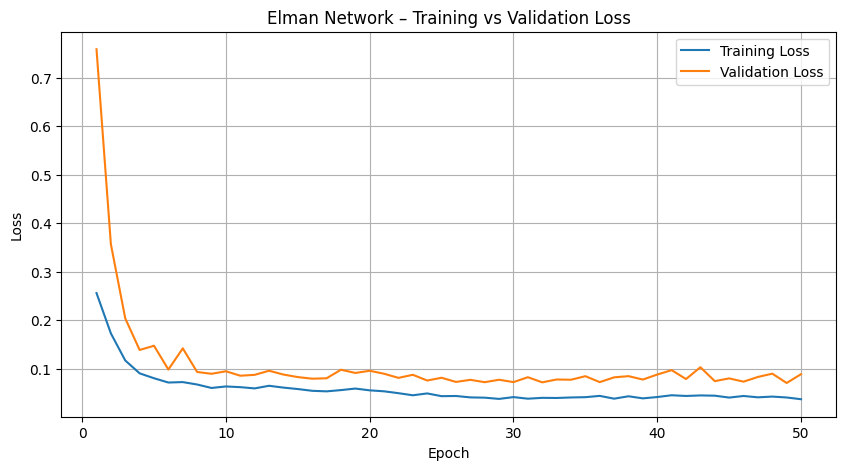

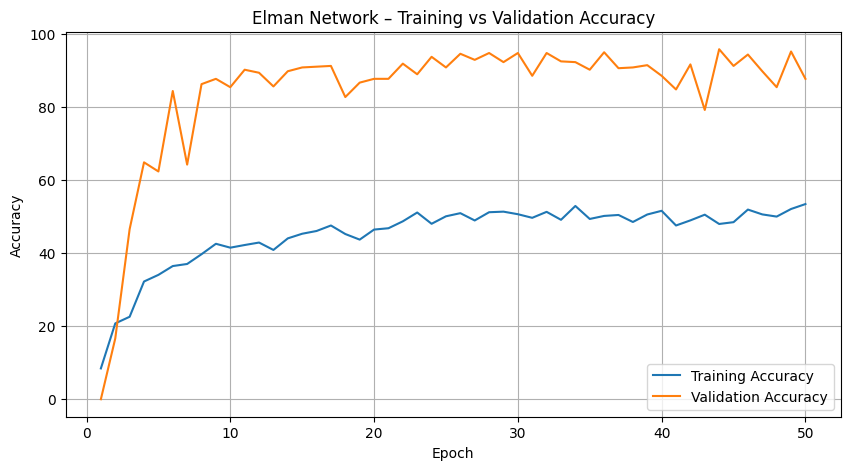

(ElmanNetworkBaselineModel(
   (recurrentNN): RNN(34, 64, batch_first=True)
   (fullyConnected): Linear(in_features=64, out_features=1, bias=True)
 ),
 {'train_loss': [0.2557178145410363,
   0.1726055150678057,
   0.11675833503271182,
   0.09027904292190041,
   0.08016944369758039,
   0.07133387270497868,
   0.07225255332471425,
   0.06725589528412997,
   0.06012602323313797,
   0.0632659996055548,
   0.06180273729494693,
   0.059253108345190646,
   0.064645250901955,
   0.06088456723045257,
   0.057918087262906814,
   0.05428605058534777,
   0.053159224868687044,
   0.055726186485219986,
   0.0589146194972297,
   0.05524936464199177,
   0.053244466949694196,
   0.049390517132656006,
   0.04504618566515165,
   0.048879773629398555,
   0.0432286387120412,
   0.04360016005714621,
   0.040702525532086295,
   0.04013048169533525,
   0.03760333024129724,
   0.0413287482360973,
   0.0380276188722314,
   0.039787453497512726,
   0.03950073209279641,
   0.04055042884607703,
   0.04115477102706

In [65]:
train_model(elman_model, 50, optimizer)

In [66]:
def evaluate_model(model, dataLoader):
    model.eval()

    totalMSE = 0.0
    totalCorrect = 0
    totalSamples = 0

    #evaluate without gradient computation
    with torch.no_grad():
        for dataX, dataY in dataLoader:
            dataX, dataY = dataX.to(device), dataY.to(device)

            #forward pass
            outputs = model(dataX)
            outputs = outputs.squeeze()

            #compute loss
            loss = lossFunction(outputs, dataY)
            totalMSE += loss.item() * dataX.size(0)

            #calculate accuracy on original scale
            totalSamples += dataX.size(0)
            preds_np = outputs.detach().cpu().numpy().reshape(-1,1)
            true_np = dataY.detach().cpu().numpy().reshape(-1,1)

            inv_preds = targetScaler.inverse_transform(preds_np).flatten()
            inv_true = targetScaler.inverse_transform(true_np).flatten()

            denom = np.where(np.abs(inv_true) < 1e-8, 1.0, np.abs(inv_true))
            totalCorrect += int(np.sum((np.abs(inv_preds - inv_true) / denom) < accuracyTolerance))

    totalAccuracy = (totalCorrect / totalSamples) * 100.0
    mseCalculation = totalMSE / len(dataLoader.dataset)
    return mseCalculation, totalAccuracy

In [67]:
#perform evaluation on test set
testLoss, testAccuracy = evaluate_model(elman_model, testLoader)

print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.2f}%")

Test Loss: 0.4151, Test Accuracy: 61.49%


### Enhanced LSTM Model

In [68]:
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1,
                 bidirectional=False):
        """
        input_size: # of input features per time step
        hidden_size: size of hidden layers of the LSTM
        output_size: size of the ouput layer
        dropout: dropout ratio
        bidirectional: if the LSTM model is bidirectional
        """
        super(EnhancedLSTMModel, self).__init__()

        # globalize parameters
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.dropout_layer = nn.Dropout(self.dropout)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        # apply batch normalization
        self.batchnorm = nn.BatchNorm1d(self.hidden_size * self.num_directions)

        # output fully-connected layer
        # self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(self.hidden_size * self.num_directions,
                            self.output_size)

        # weight initialization
        self.init_weights()

    def init_weights(self):
        # LSTM parameters initialization as 0
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

        # fc parameters initialization as 0
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def get_name(self):
        return "Enhanced LSTM"

    def forward(self, input):
        """
        input: (batch_size, len_sequence, input_size)
        output: (batch_size, output_size)
        """
        # dropout
        dropout_out = self.dropout_layer(input)

        # LSTM layer
        lstm_out, (h_last, c_last) = self.lstm(dropout_out)

        # making prediction based on the output of the last time step
        lstm_out_last = lstm_out[:, -1, :]

        # batch normalization
        # bn_out = self.batchnorm(lstm_out_last)

        # output fully-connected layer
        # relu_out = self.relu(lstm_out_last)
        tanh_out = self.tanh(lstm_out_last)
        output = self.fc(tanh_out)
        # output = self.fc(lstm_out_last)
        output = output.squeeze(-1)

        return output

Epoch [1/50], Train Loss: 0.1802, Validation Loss: 0.2135, Train Accuracy: 21.85%, Validation Accuracy: 43.87%
Epoch [2/50], Train Loss: 0.2044, Validation Loss: 0.3506, Train Accuracy: 19.08%, Validation Accuracy: 32.43%
Epoch [3/50], Train Loss: 0.1786, Validation Loss: 0.3705, Train Accuracy: 15.36%, Validation Accuracy: 31.39%
Epoch [4/50], Train Loss: 0.1084, Validation Loss: 0.2170, Train Accuracy: 32.62%, Validation Accuracy: 50.73%
Epoch [5/50], Train Loss: 0.0987, Validation Loss: 0.2311, Train Accuracy: 35.95%, Validation Accuracy: 47.82%
Epoch [6/50], Train Loss: 0.0894, Validation Loss: 0.1557, Train Accuracy: 32.83%, Validation Accuracy: 61.75%
Epoch [7/50], Train Loss: 0.0657, Validation Loss: 0.2086, Train Accuracy: 37.63%, Validation Accuracy: 48.23%
Epoch [8/50], Train Loss: 0.0631, Validation Loss: 0.1340, Train Accuracy: 39.66%, Validation Accuracy: 70.89%
Epoch [9/50], Train Loss: 0.0614, Validation Loss: 0.1532, Train Accuracy: 36.34%, Validation Accuracy: 57.17%
E

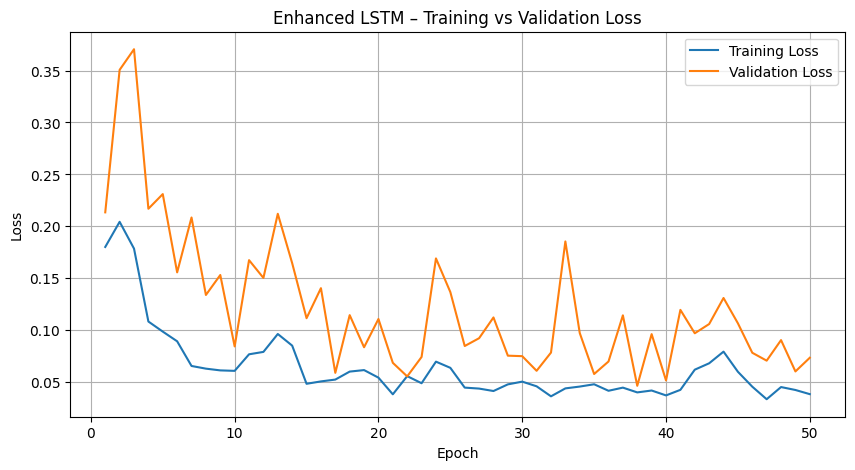

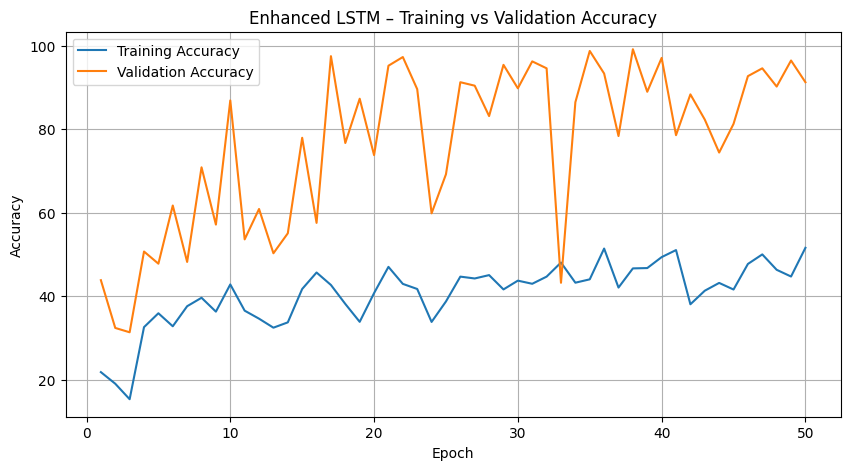

(EnhancedLSTMModel(
   (dropout_layer): Dropout(p=0.0, inplace=False)
   (lstm): LSTM(34, 64, num_layers=2, batch_first=True)
   (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (tanh): Tanh()
   (fc): Linear(in_features=64, out_features=1, bias=True)
 ),
 {'train_loss': [0.18019771330346698,
   0.2044021245135662,
   0.17860848297863666,
   0.10843778614901332,
   0.09874192852494997,
   0.08942557050868996,
   0.06567315772937671,
   0.06309733279349121,
   0.06141997305175994,
   0.06097200121116613,
   0.07690914196938532,
   0.0792155180821597,
   0.09644428046375257,
   0.0852530488941133,
   0.048521551021485705,
   0.050821786851286424,
   0.05257867169927814,
   0.06026571322316601,
   0.06170909343030649,
   0.05443359505362923,
   0.038400235495225754,
   0.055893295394996836,
   0.04906557255264787,
   0.0698357650267128,
   0.06388428993281407,
   0.04484831526597042,
   0.043913944308444676,
   0.041569965611393964,
   0.0479

In [69]:
enhanced_input_size = numFeatures
enhanced_hidden_size = 64
enhanced_output_size = 1
enhanced_model = EnhancedLSTMModel(enhanced_input_size,
                                   enhanced_hidden_size,
                                   enhanced_output_size,
                                   bidirectional=False,
                                   dropout=0.0,
                                   ).to(device)

enhanced_optimizer = optim.Adam(enhanced_model.parameters(),
                       lr=0.001, weight_decay=1e-4)

train_model(enhanced_model, 50, enhanced_optimizer)

In [70]:
enhanced_test_loss, enhanced_test_accuracy = evaluate_model(
    enhanced_model, testLoader)
print(f"Test Loss: {enhanced_test_loss:.4f}, Test Accuracy: {enhanced_test_accuracy:.2f}%")

Test Loss: 0.3618, Test Accuracy: 67.70%


In [71]:
def enhanced_train(hidden_size, dropout, weight_decay, lr=1e-3, num_epochs=30):
  enhanced_input_size = numFeatures
  # enhanced_hidden_size = 64
  enhanced_output_size = 1
  enhanced_model = EnhancedLSTMModel(enhanced_input_size,
                                    hidden_size,
                                    enhanced_output_size,
                                    bidirectional=False,
                                    dropout=dropout,
                                    ).to(device)

  enhanced_optimizer = optim.Adam(enhanced_model.parameters(),
                        lr=lr, weight_decay=weight_decay)

  print(f"Training w/ hidden_size={hidden_size}, dropout={dropout}, "
          f"weight_decay={weight_decay}, lr={lr}")

  trained_model, history = train_model(enhanced_model, num_epochs, enhanced_optimizer)

  # final_val_loss = min(history['val_loss'])
  final_val_loss = history['val_loss'][-1]

  return trained_model, history, final_val_loss

In [72]:
def hyperparameter_tune(hidden_sizes=[64,128], learning_rate=0.001,dropouts=[0.0,0.1], num_epochs=30, weight_decay=[1e-3, 1e-4]):
  best_model = None
  tuned_hyperparameters = None # Initialize tuned_hyperparameters
  best_validation_loss = float('inf')
  tuning_results = []

  for hidden_size in hidden_sizes:
    for dropout in dropouts:
      for wd in weight_decay:
        trained_model, history, val_loss = enhanced_train(hidden_size, dropout, wd, lr=learning_rate, num_epochs=num_epochs)
        tuning_results.append({
            'hidden_size': hidden_size,
            'dropout': dropout,
            'weight_decay': wd,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'val_loss': val_loss,
        })

        if val_loss < best_validation_loss:
          best_model = trained_model
          best_validation_loss = val_loss
          tuned_hyperparameters = {
              'hidden_size': hidden_size,
              'dropout': dropout,
              'weight_decay': wd,
              'learning_rate': learning_rate,
              'num_epochs': num_epochs,
              'val_loss': val_loss,
          }

  return best_model, tuned_hyperparameters, tuning_results

Training w/ hidden_size=64, dropout=0.0, weight_decay=0.001, lr=0.001
Epoch [1/30], Train Loss: 0.1904, Validation Loss: 0.2064, Train Accuracy: 19.67%, Validation Accuracy: 48.65%
Epoch [2/30], Train Loss: 0.2164, Validation Loss: 0.4726, Train Accuracy: 16.07%, Validation Accuracy: 13.51%
Epoch [3/30], Train Loss: 0.1321, Validation Loss: 0.2231, Train Accuracy: 23.59%, Validation Accuracy: 50.10%
Epoch [4/30], Train Loss: 0.1519, Validation Loss: 0.4837, Train Accuracy: 28.52%, Validation Accuracy: 9.98%
Epoch [5/30], Train Loss: 0.1009, Validation Loss: 0.1685, Train Accuracy: 34.70%, Validation Accuracy: 57.80%
Epoch [6/30], Train Loss: 0.0944, Validation Loss: 0.2175, Train Accuracy: 37.97%, Validation Accuracy: 52.60%
Epoch [7/30], Train Loss: 0.1203, Validation Loss: 0.2868, Train Accuracy: 33.82%, Validation Accuracy: 47.82%
Epoch [8/30], Train Loss: 0.0800, Validation Loss: 0.1604, Train Accuracy: 37.32%, Validation Accuracy: 58.00%
Epoch [9/30], Train Loss: 0.0710, Validatio

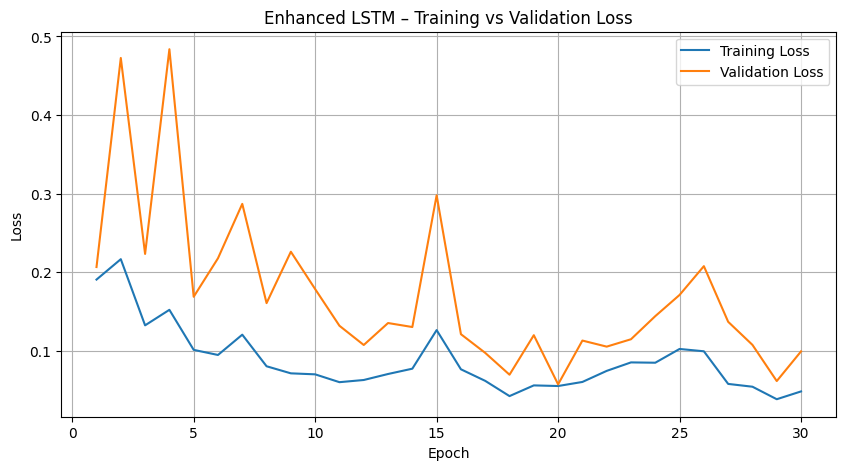

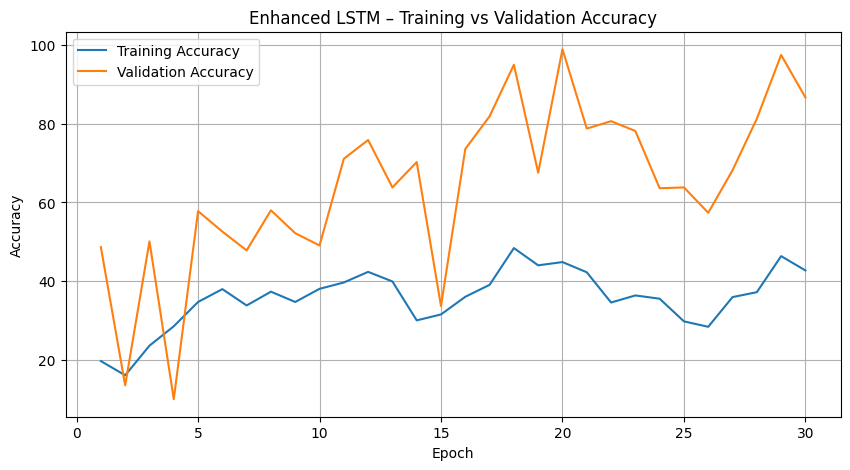

Training w/ hidden_size=64, dropout=0.0, weight_decay=0.0001, lr=0.001
Epoch [1/30], Train Loss: 0.1591, Validation Loss: 0.2080, Train Accuracy: 25.23%, Validation Accuracy: 43.66%
Epoch [2/30], Train Loss: 0.2595, Validation Loss: 0.7382, Train Accuracy: 14.14%, Validation Accuracy: 0.21%
Epoch [3/30], Train Loss: 0.1116, Validation Loss: 0.1381, Train Accuracy: 27.30%, Validation Accuracy: 65.28%
Epoch [4/30], Train Loss: 0.0773, Validation Loss: 0.1627, Train Accuracy: 38.83%, Validation Accuracy: 57.80%
Epoch [5/30], Train Loss: 0.1102, Validation Loss: 0.1343, Train Accuracy: 29.20%, Validation Accuracy: 69.65%
Epoch [6/30], Train Loss: 0.1490, Validation Loss: 0.3463, Train Accuracy: 27.67%, Validation Accuracy: 25.99%
Epoch [7/30], Train Loss: 0.0905, Validation Loss: 0.1526, Train Accuracy: 34.34%, Validation Accuracy: 55.30%
Epoch [8/30], Train Loss: 0.0621, Validation Loss: 0.1258, Train Accuracy: 40.54%, Validation Accuracy: 68.61%
Epoch [9/30], Train Loss: 0.0733, Validati

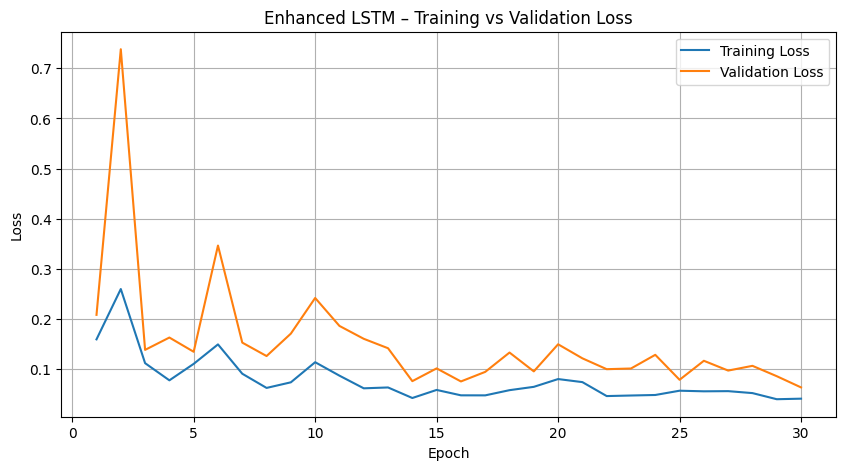

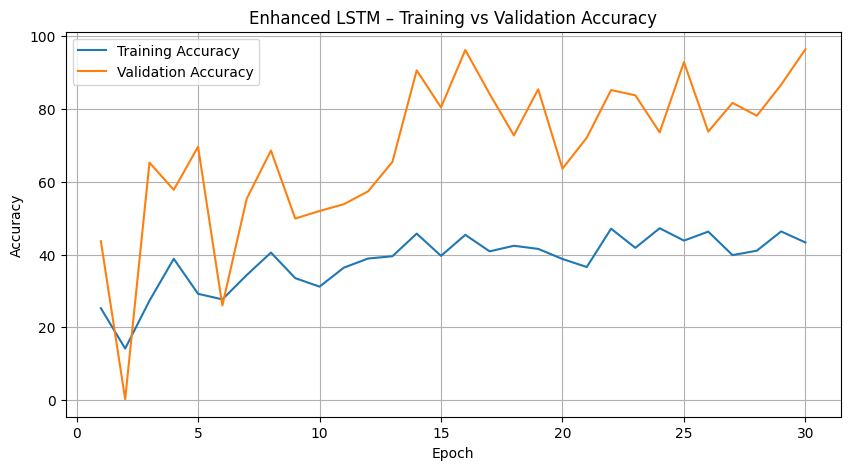

Training w/ hidden_size=64, dropout=0.1, weight_decay=0.001, lr=0.001
Epoch [1/30], Train Loss: 0.1840, Validation Loss: 0.1307, Train Accuracy: 18.45%, Validation Accuracy: 71.52%
Epoch [2/30], Train Loss: 0.2145, Validation Loss: 0.2960, Train Accuracy: 15.52%, Validation Accuracy: 33.47%
Epoch [3/30], Train Loss: 0.1543, Validation Loss: 0.3462, Train Accuracy: 21.70%, Validation Accuracy: 24.95%
Epoch [4/30], Train Loss: 0.1433, Validation Loss: 0.4677, Train Accuracy: 25.56%, Validation Accuracy: 12.89%
Epoch [5/30], Train Loss: 0.1058, Validation Loss: 0.1872, Train Accuracy: 31.38%, Validation Accuracy: 54.89%
Epoch [6/30], Train Loss: 0.0921, Validation Loss: 0.1735, Train Accuracy: 35.79%, Validation Accuracy: 61.75%
Epoch [7/30], Train Loss: 0.0924, Validation Loss: 0.1931, Train Accuracy: 30.68%, Validation Accuracy: 55.09%
Epoch [8/30], Train Loss: 0.0768, Validation Loss: 0.1339, Train Accuracy: 38.26%, Validation Accuracy: 65.90%
Epoch [9/30], Train Loss: 0.0776, Validati

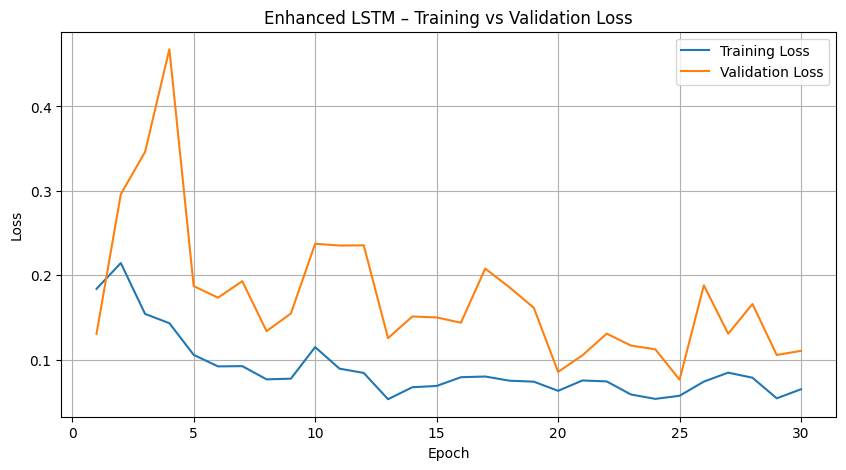

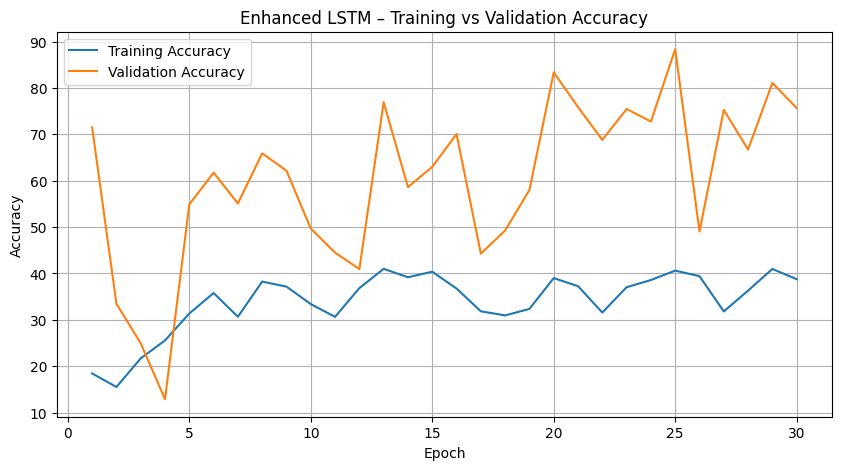

Training w/ hidden_size=64, dropout=0.1, weight_decay=0.0001, lr=0.001
Epoch [1/30], Train Loss: 0.1952, Validation Loss: 0.1885, Train Accuracy: 22.03%, Validation Accuracy: 53.22%
Epoch [2/30], Train Loss: 0.2350, Validation Loss: 0.6534, Train Accuracy: 14.85%, Validation Accuracy: 0.00%
Epoch [3/30], Train Loss: 0.1468, Validation Loss: 0.3740, Train Accuracy: 25.75%, Validation Accuracy: 17.05%
Epoch [4/30], Train Loss: 0.1384, Validation Loss: 0.5273, Train Accuracy: 28.91%, Validation Accuracy: 2.49%
Epoch [5/30], Train Loss: 0.1036, Validation Loss: 0.1599, Train Accuracy: 32.78%, Validation Accuracy: 64.03%
Epoch [6/30], Train Loss: 0.0837, Validation Loss: 0.1968, Train Accuracy: 38.26%, Validation Accuracy: 55.09%
Epoch [7/30], Train Loss: 0.1094, Validation Loss: 0.2365, Train Accuracy: 31.77%, Validation Accuracy: 52.18%
Epoch [8/30], Train Loss: 0.0680, Validation Loss: 0.1961, Train Accuracy: 35.53%, Validation Accuracy: 51.77%
Epoch [9/30], Train Loss: 0.0706, Validatio

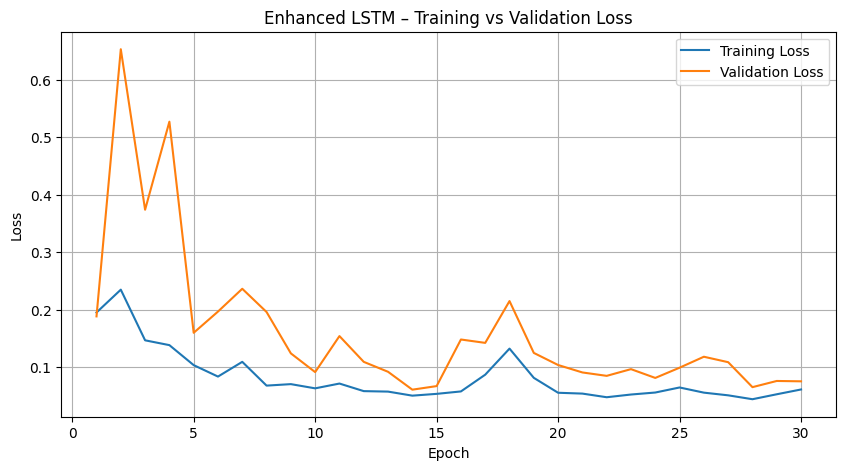

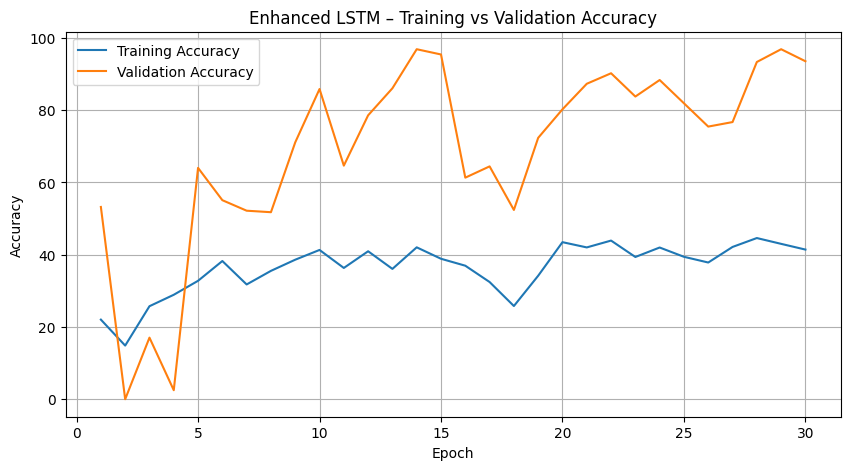

Training w/ hidden_size=128, dropout=0.0, weight_decay=0.001, lr=0.001
Epoch [1/30], Train Loss: 0.1837, Validation Loss: 0.2706, Train Accuracy: 21.65%, Validation Accuracy: 35.76%
Epoch [2/30], Train Loss: 0.2324, Validation Loss: 0.4019, Train Accuracy: 16.58%, Validation Accuracy: 12.06%
Epoch [3/30], Train Loss: 0.1624, Validation Loss: 0.3875, Train Accuracy: 23.75%, Validation Accuracy: 13.93%
Epoch [4/30], Train Loss: 0.1565, Validation Loss: 0.4440, Train Accuracy: 28.00%, Validation Accuracy: 11.43%
Epoch [5/30], Train Loss: 0.1196, Validation Loss: 0.1872, Train Accuracy: 31.14%, Validation Accuracy: 57.59%
Epoch [6/30], Train Loss: 0.1235, Validation Loss: 0.2806, Train Accuracy: 33.14%, Validation Accuracy: 37.84%
Epoch [7/30], Train Loss: 0.1258, Validation Loss: 0.2148, Train Accuracy: 33.84%, Validation Accuracy: 54.68%
Epoch [8/30], Train Loss: 0.1104, Validation Loss: 0.2252, Train Accuracy: 27.33%, Validation Accuracy: 49.27%
Epoch [9/30], Train Loss: 0.1089, Validat

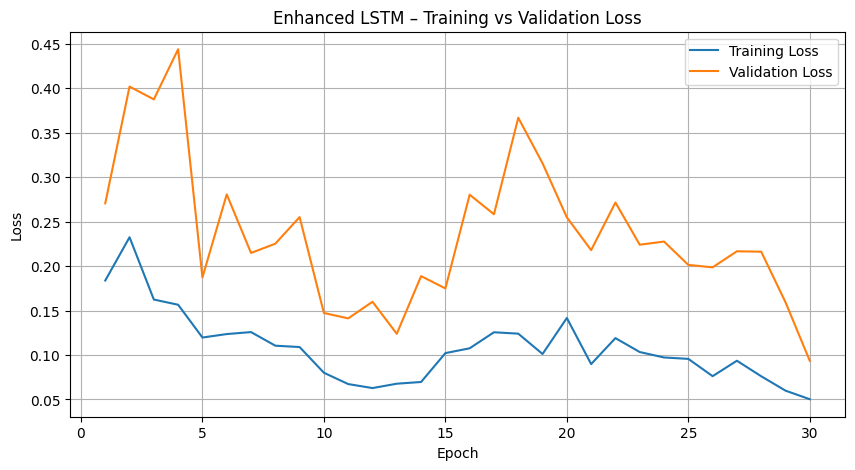

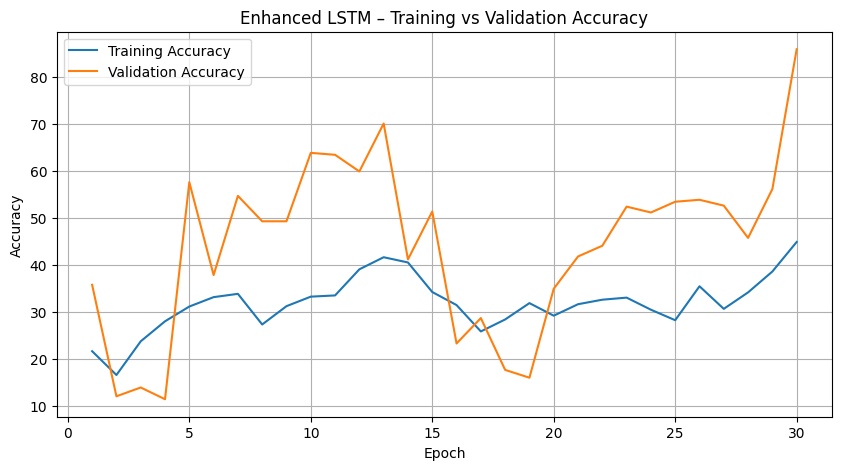

Training w/ hidden_size=128, dropout=0.0, weight_decay=0.0001, lr=0.001
Epoch [1/30], Train Loss: 0.1778, Validation Loss: 0.2456, Train Accuracy: 20.56%, Validation Accuracy: 39.29%
Epoch [2/30], Train Loss: 0.2632, Validation Loss: 0.4108, Train Accuracy: 12.25%, Validation Accuracy: 4.78%
Epoch [3/30], Train Loss: 0.2053, Validation Loss: 0.4554, Train Accuracy: 15.23%, Validation Accuracy: 9.77%
Epoch [4/30], Train Loss: 0.1515, Validation Loss: 0.2380, Train Accuracy: 20.92%, Validation Accuracy: 52.18%
Epoch [5/30], Train Loss: 0.1426, Validation Loss: 0.4349, Train Accuracy: 21.98%, Validation Accuracy: 21.21%
Epoch [6/30], Train Loss: 0.1141, Validation Loss: 0.1867, Train Accuracy: 24.63%, Validation Accuracy: 55.93%
Epoch [7/30], Train Loss: 0.1054, Validation Loss: 0.2126, Train Accuracy: 30.78%, Validation Accuracy: 53.43%
Epoch [8/30], Train Loss: 0.0863, Validation Loss: 0.1658, Train Accuracy: 34.08%, Validation Accuracy: 61.12%
Epoch [9/30], Train Loss: 0.0770, Validati

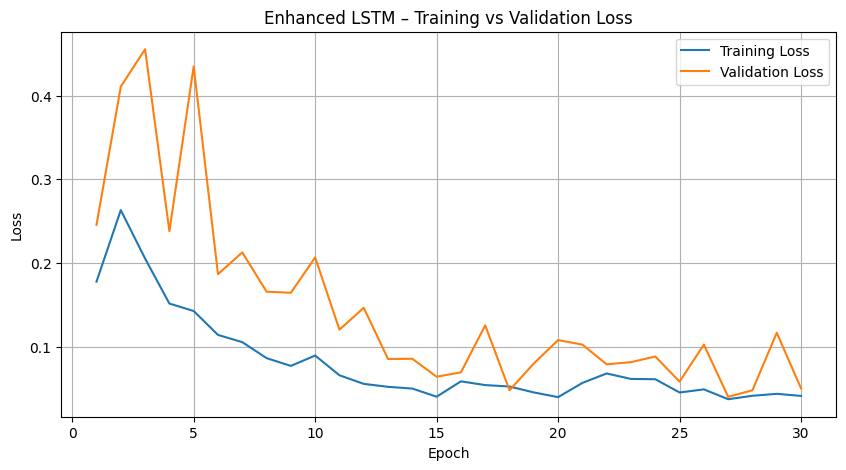

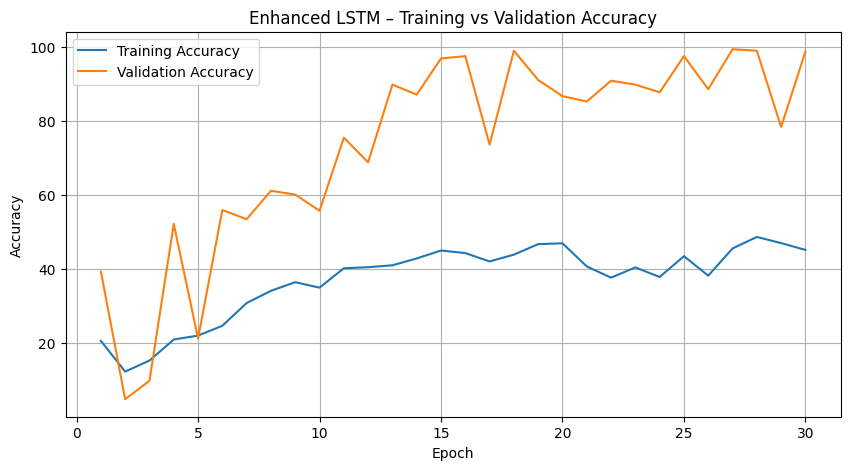

Training w/ hidden_size=128, dropout=0.1, weight_decay=0.001, lr=0.001
Epoch [1/30], Train Loss: 0.1806, Validation Loss: 0.1721, Train Accuracy: 17.70%, Validation Accuracy: 58.84%
Epoch [2/30], Train Loss: 0.2406, Validation Loss: 0.3406, Train Accuracy: 17.96%, Validation Accuracy: 13.51%
Epoch [3/30], Train Loss: 0.1755, Validation Loss: 0.3068, Train Accuracy: 21.80%, Validation Accuracy: 29.31%
Epoch [4/30], Train Loss: 0.1561, Validation Loss: 0.4017, Train Accuracy: 27.56%, Validation Accuracy: 10.60%
Epoch [5/30], Train Loss: 0.1339, Validation Loss: 0.2318, Train Accuracy: 28.39%, Validation Accuracy: 51.35%
Epoch [6/30], Train Loss: 0.1349, Validation Loss: 0.3046, Train Accuracy: 29.20%, Validation Accuracy: 33.47%
Epoch [7/30], Train Loss: 0.1134, Validation Loss: 0.2031, Train Accuracy: 28.16%, Validation Accuracy: 53.85%
Epoch [8/30], Train Loss: 0.1116, Validation Loss: 0.2460, Train Accuracy: 29.04%, Validation Accuracy: 46.57%
Epoch [9/30], Train Loss: 0.1081, Validat

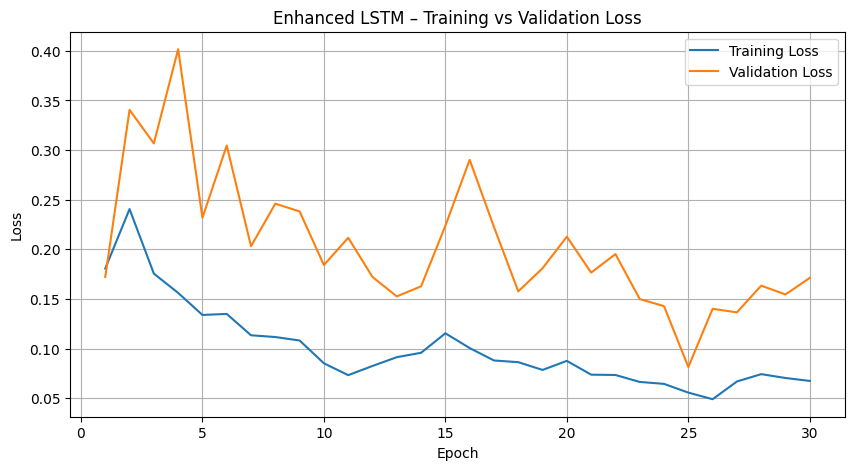

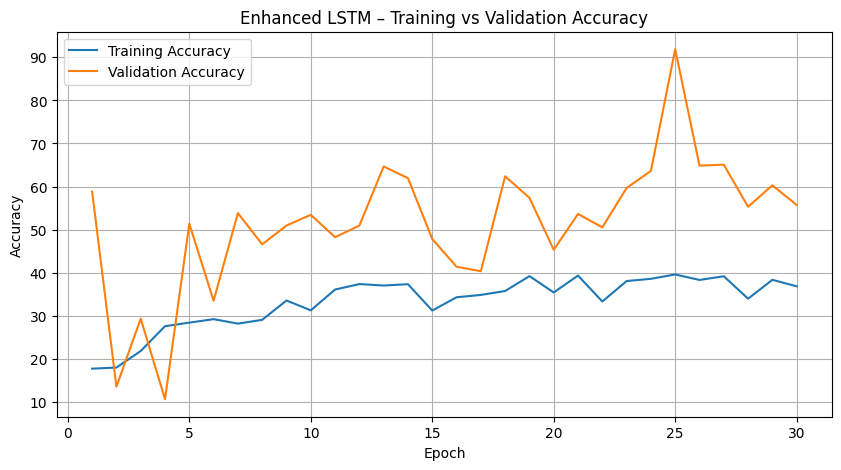

Training w/ hidden_size=128, dropout=0.1, weight_decay=0.0001, lr=0.001
Epoch [1/30], Train Loss: 0.1813, Validation Loss: 0.1513, Train Accuracy: 18.74%, Validation Accuracy: 62.79%
Epoch [2/30], Train Loss: 0.2374, Validation Loss: 0.2380, Train Accuracy: 11.89%, Validation Accuracy: 36.59%
Epoch [3/30], Train Loss: 0.2222, Validation Loss: 0.2774, Train Accuracy: 15.21%, Validation Accuracy: 41.58%
Epoch [4/30], Train Loss: 0.1898, Validation Loss: 0.4020, Train Accuracy: 19.10%, Validation Accuracy: 24.95%
Epoch [5/30], Train Loss: 0.1331, Validation Loss: 0.2631, Train Accuracy: 26.01%, Validation Accuracy: 45.53%
Epoch [6/30], Train Loss: 0.1457, Validation Loss: 0.4155, Train Accuracy: 26.60%, Validation Accuracy: 25.57%
Epoch [7/30], Train Loss: 0.0938, Validation Loss: 0.1891, Train Accuracy: 32.00%, Validation Accuracy: 58.63%
Epoch [8/30], Train Loss: 0.0949, Validation Loss: 0.2420, Train Accuracy: 35.53%, Validation Accuracy: 51.14%
Epoch [9/30], Train Loss: 0.0858, Valida

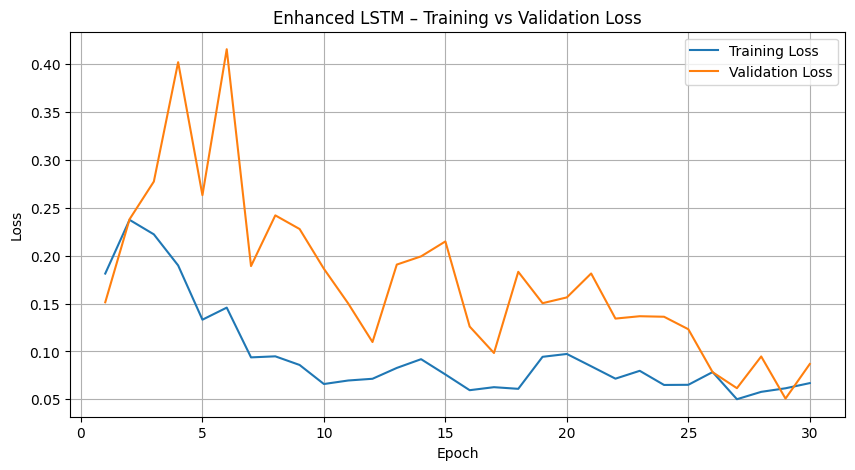

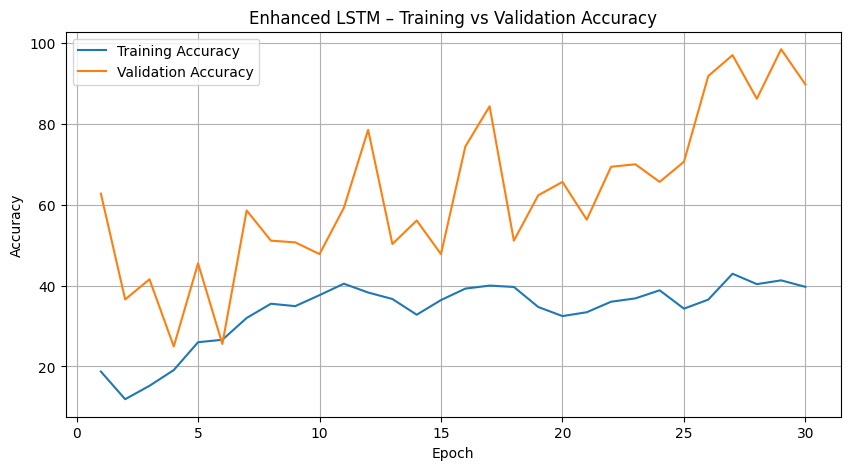

Test Loss: 0.2966, Test Accuracy: 68.53%


In [78]:
best_model, best_hyperparameters, tuning_results = hyperparameter_tune()

enhanced_test_loss, enhanced_test_accuracy = evaluate_model(
    best_model, testLoader)
print(f"Test Loss: {enhanced_test_loss:.4f}, Test Accuracy: {enhanced_test_accuracy:.2f}%")

In [79]:
enhanced_test_loss, enhanced_test_accuracy = evaluate_model(
    best_model, testLoader)
print(f"Test Loss: {enhanced_test_loss:.4f}, Test Accuracy: {enhanced_test_accuracy:.2f}%")

Test Loss: 0.2966, Test Accuracy: 68.53%


In [75]:
print(best_model)
print(best_hyperparameters)

EnhancedLSTMModel(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(34, 64, num_layers=2, batch_first=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
{'hidden_size': 64, 'dropout': 0.1, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'num_epochs': 30, 'val_loss': 0.08835800844021993}
